In [79]:
# GPS Algorithm Code 실행 방법
# 1. Anaconda 가상환경 새로 만들기 (conda create -n <환경이름> python=3.8.5)
# 2. conda activate <환경이름>
# 3. (환경이름) >> conda install matplotlib=3.3.2 pandas=1.2.4 numpy=1.19.2 jupyter
# 4. (환경이름) >> conda install -c conda-forge haversine
# 5. (환경이름) >> conda install -c conda-forge folium
# 6. >> jupyter notebook

In [80]:
# 전역 변수 설정
PATIENT_UID = '2DDB3706DE4F7B45'# 감염자 UID
# TARGET_UID =  # 조사 대상자 UID

FILE_SAVE_DIR = './' #있다면 추가 해주기 (상대경로)
line_color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
                    'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] 

In [81]:
import pandas as pd
import numpy as np
from csv import reader
from numpy import linalg as la
from sys import exit
from haversine import haversine
import math
from operator import itemgetter

#시각화 도구
import folium
from folium.features import DivIcon

In [82]:
#Call CSV file
def load_GPS_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_gps"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME'])
        data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME","UID","altitude","latitude","longitude","provider"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass
def load_Sateillate_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_sate"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME'])
        data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME","UID","SNR AVERAGE","SATELLITE COUNT"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass

def merge_gps_sati_set(gps_df, UID): # for weight_filter
    merge_df = pd.merge(gps_df,load_Sateillate_set(UID), how='left', on = ['TIME','UID'])
    return merge_df

test_df = load_GPS_set(PATIENT_UID)
merge_df = merge_gps_sati_set(test_df,PATIENT_UID)



In [83]:
map_1 = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
marker_list = [[0,0],[0,0]]
line_list = []
extract_list = []
total_list = []


for count in test_df.index.values[120:131]:
    marker_point_lati = float(test_df.loc[count,'latitude'])
    marker_point_long = float(test_df.loc[count,'longitude'])
    marker_point = [marker_point_lati, marker_point_long]
    
    folium.Marker(marker_point, icon=DivIcon(icon_size=(10,3),icon_anchor=(7,20),
            html='<div style="font-size: 5pt; color : black">'+str(count)+'</div>',
            )).add_to(map_1)
    
    
    marker_list.pop(0)
    marker_list.append(marker_point)
    total_list.append(marker_point)
    if count == 0 :
        line_list.append(marker_point)
        pass
    else :
        gps_dis = haversine(marker_list[0], marker_list[1]) * 1000 #(m) 
        if gps_dis > 50 : #GPS 거리로 1분에 50m 이상 이동했을경우 튄값이라고 생각하고 배제
            extract_list.append(marker_point)
            pass

        elif (gps_dis <= 50) & (gps_dis != 0) :
#             folium.Marker(marker_point, popup=count, icon=DivIcon(icon_size=(10,3),icon_anchor=(7,20),
#             html='<div style="font-size: 5pt; color : black">'+str(count)+'</div>',
#             )).add_to(map_1)
            line_list.append(marker_point)
    

folium.PolyLine(locations=line_list,tooltip='Polyline',color='blue').add_to(map_1)
folium.PolyLine(locations=extract_list,tooltip='Polyline',color='red').add_to(map_1) # 1분당 최소 이동거리 70N이상 Red Line
folium.PolyLine(locations=total_list,tooltip='Polyline',color='green').add_to(map_1)

# map_1
    #m.add_child(folium.CircleMarker(p1, radius=15))

In [84]:
map_2 = folium.Map(location = [37.5505938572,127.074236903], zoom_start =16) # 세종대학교 중심 조사
marker_list = [[0,0],[0,0]]
line_list = []
cluster_list = [] #clustering list
clustering_size = 10
res_list = []
                
                
mean_point_list = [] # filtering point list
for count in test_df.index.values[120:131]:
    
    marker_point_lati = float(test_df.loc[count,'latitude'])
    marker_point_long = float(test_df.loc[count,'longitude'])
    marker_point = [marker_point_lati, marker_point_long]
    
#     folium.Marker(marker_point, icon=DivIcon(icon_size=(10,3),icon_anchor=(7,20),
#             html='<div style="font-size: 5pt; color : black">'+str(count)+'</div>',
#             )).add_to(map)
    
    if len(cluster_list) != clustering_size:
        cluster_list.append(marker_point)


    else : # cluster_list full
        for point in range(0, clustering_size-1): # Depth Level 1

            current_point = cluster_list[point]
            next_point = cluster_list[point+1]
            mean_point_x = (current_point[0] + next_point[0])/2
            mean_point_y = (current_point[1] + next_point[1])/2
            mean_point = [mean_point_x, mean_point_y]

            mean_point_list.append(mean_point)
folium.PolyLine(locations=mean_point_list,tooltip='Polyline', color='blue').add_to(map_2)
# map_2

In [85]:
#GPS FIllering by Clustering for Mean Filter
Mean_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
marker_list = [[0,0],[0,0]]
mean_cluster_list = [] #clustering list
clustering_size = 10
res_list = []
Depth_Level = 4       
mean_point_list = [] # filtering point list
######################################################################

for count in test_df.index.values[120:131]:
    marker_point_lati = float(test_df.loc[count,'latitude'])
    marker_point_long = float(test_df.loc[count,'longitude'])
    marker_point = [marker_point_lati, marker_point_long]
    
    if len(mean_cluster_list) != clustering_size: # cluster_list isnot full
        mean_cluster_list.append(marker_point)
        continue
   
    else : # mean_cluster_list full
        while True:
            res_list.append(mean_cluster_list) # depth별 list
            if len(mean_cluster_list) == Depth_Level:
                break
            for point in range(0, len(mean_cluster_list)-1): # Depth Level 1

                current_point = mean_cluster_list[point]
                next_point = mean_cluster_list[point+1]
                mean_point_x = (current_point[0] + next_point[0])/2
                mean_point_y = (current_point[1] + next_point[1])/2
                mean_point = [mean_point_x, mean_point_y]

                mean_point_list.append(mean_point)
            mean_cluster_list = mean_point_list
            mean_point_list =[] # mean_point_list clear

folium.PolyLine(locations=mean_cluster_list,tooltip='Polyline', color='blue').add_to(Mean_map) # draw line

# for index in range(0, len(res_list)):
#     folium.PolyLine(locations=res_list[index],tooltip='Polyline', color=line_color_list[index]).add_to(Mean_map)

# Mean_map  


In [86]:
#GPS FIllering by Clustering for weight Filter
weight_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
weight_cluster_list = [] #clustering list
clustering_size = 10
res_list = []
Depth_Level = 9     
weight_point_list = [] # filtering point list
######################################################################

for count in test_df.index.values[120:222]:
    level = 0
    marker_point_lati = float(merge_df.loc[count,'latitude'])
    marker_point_long = float(merge_df.loc[count,'longitude'])
    if merge_df.loc[count,'SATELLITE COUNT'] == np.nan : #위성정보가 오류로 수집이 안되었을 경우 0으로 처리
        marker_point_count = 0 # weight
    else:
        marker_point_count = int(merge_df.loc[count,'SATELLITE COUNT']) # weight
    marker_point = [marker_point_lati, marker_point_long, marker_point_count]
    
    if len(weight_cluster_list) != clustering_size: # cluster_list isnot full
        weight_cluster_list.append(marker_point)
        continue
   
    else : # cluster_list full
        while True:
            res_list.append(weight_cluster_list) # depth별 list
            if len(weight_cluster_list) == Depth_Level:
                for index in range(0, len(res_list)): # 지도에 표시하기 위해 list에서 weight 제거 작업
                    for count in range(0, len(res_list[index])):
                        res_list[index][count] = res_list[index][count][:2]
                break
            for point in range(0, len(weight_cluster_list)-1): # Depth Level 1
                current_point = weight_cluster_list[point]
                next_point = weight_cluster_list[point+1]
                weight_point_x = (current_point[2]*current_point[0] + next_point[2]*next_point[0])/(current_point[2]+next_point[2]) #기존 내분점 공식을 그대로 적용하면 x, 변형 필요
                weight_point_y = (current_point[2]*current_point[1] + next_point[2]*next_point[1])/(current_point[2]+next_point[2])
                weight_point_count = current_point[2] + next_point[2]
                weight_point = [weight_point_x, weight_point_y, weight_point_count]

                weight_point_list.append(weight_point)
            weight_cluster_list = weight_point_list
            weight_point_list =[] # weight_point_list clear
            level = level + 1

# folium.PolyLine(locations=weight_cluster_list,tooltip='Polyline', color='blue').add_to(weight_map) # draw line
for index in range(0, len(res_list)):
    folium.PolyLine(locations=res_list[index],tooltip='Polyline', color=line_color_list[index]).add_to(weight_map)

# weight_map  


IndexError: list index out of range

In [ ]:
#GPS FIllering by Clustering for Centriod Filter
def Centriod_Filter():
    Centriod_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =16) # 세종대학교 중심 조사
    Centriod_cluster_list = [] #clustering list
    clustering_size = 8
    res_list = []
    Depth_Level = 2 # must even constant      
    Centriod_point_list = [] # filtering point list
    ######################################################################

    for count in test_df.index.values[120:131]:
        marker_point_lati = float(test_df.loc[count,'latitude'])
        marker_point_long = float(test_df.loc[count,'longitude'])
        marker_point = [marker_point_lati, marker_point_long]
        
        if len(Centriod_cluster_list) != clustering_size: # cluster_list isnot full
            Centriod_cluster_list.append(marker_point)
            continue
    
        else : # cluster_list full
            while True:
                res_list.append(Centriod_cluster_list) # depth별 list
                if len(Centriod_cluster_list) == Depth_Level:
                    break
                for point in range(0, len(Centriod_cluster_list)-2): # Depth Level 1

                    current_point = Centriod_cluster_list[point]
                    second_point = Centriod_cluster_list[point+1]
                    third_point = Centriod_cluster_list[point+2]
                    Centriod_point_x = (current_point[0] + second_point[0] + third_point[0])/3
                    Centriod_point_y = (current_point[1] + second_point[1] + third_point[1])/3
                    Centriod_point = [Centriod_point_x, Centriod_point_y]

                    Centriod_point_list.append(Centriod_point)
                Centriod_cluster_list = Centriod_point_list
                Centriod_point_list =[] # mean_point_list clear

    # folium.PolyLine(locations=Centriod_cluster_list,tooltip='Polyline', color='blue').add_to(Centriod_map) # draw line

    for index in range(0, len(res_list)):
        folium.PolyLine(locations=res_list[index],tooltip='Polyline', color=line_color_list[index]).add_to(Centriod_map)

    # Centriod_map  


In [ ]:
#GPS FIllering by Clustering + PreFilter
Mass_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
Mass_cluster_list = [] #clustering list
clustering_size = 7 #(minute)
res_list = [] # result list
######################################################################

for count in test_df.index.values[120:223]:
    marker_point_lati = float(test_df.loc[count,'latitude'])
    marker_point_long = float(test_df.loc[count,'longitude'])
    marker_point = [marker_point_lati, marker_point_long]

    # 전처리 과정
    if len(Mass_cluster_list) < clustering_size: # cluster_list isnot full
        if len(Mass_cluster_list) >= 1:
            gps_dis = haversine(Mass_cluster_list[len(Mass_cluster_list)-1], marker_point) * 1000 #(m) 
            if gps_dis > 50:
                replace_point_x = (Mass_cluster_list[len(Mass_cluster_list)-1][0] + marker_point[0]) / 2
                replace_point_y = (Mass_cluster_list[len(Mass_cluster_list)-1][1] + marker_point[1]) / 2
                replace_point = [replace_point_x, replace_point_y]
                # Mass_cluster_list.append(Mass_cluster_list[len(Mass_cluster_list)-1]) # 이전 포인트를 그대로 넣느냐
                Mass_cluster_list.append(replace_point) # Mean Point로 대체해서 넣느냐
            else :
                Mass_cluster_list.append(marker_point)
        else:
            Mass_cluster_list.append(marker_point)
   
    else: # cluster_list full
        sum_point_x = 0
        sum_point_y = 0
        for idx in range(0,clustering_size):
            sum_point_x += Mass_cluster_list[idx][0]
            sum_point_y += Mass_cluster_list[idx][1]
        mass_point = [sum_point_x/clustering_size, sum_point_y/clustering_size]
        res_list.append(mass_point)
        Mass_cluster_list.pop(0)

        

# print(res_list)
# folium.PolyLine(locations=res_list,tooltip='Polyline', color='blue').add_to(Mass_map) # draw line

# for index in range(0, len(res_list)):
#     folium.PolyLine(locations=res_list[index],tooltip='Polyline', color=line_color_list[index]).add_to(Centriod_map)

# Mass_map  


In [93]:
#GPS FIllering by Clustering + PreFilter by speed vector
filtering_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
Mass_cluster_list = [] #clustering list
speed_vector_list = []
raw_list = []
norm_list = []
clustering_size = 3 #(minute)
res_list = [] # result list
ERROR_WEIGHT = 5
######################################################################

for count in test_df.index.values[120:223]:
    marker_point_lati = float(test_df.loc[count,'latitude'])
    marker_point_long = float(test_df.loc[count,'longitude'])
    marker_point = [marker_point_lati, marker_point_long]
    raw_list.append(marker_point)
    # 전처리 과정


    if len(Mass_cluster_list) < clustering_size: # cluster_list isnot full
        Mass_cluster_list.append(marker_point)
            # gps_dis = haversine(, ) * 1000 #(m) 
   
    else: # cluster_list full
        sum_point_x = 0
        sum_point_y = 0
        for idx in range(0,clustering_size):
            sum_point_x += Mass_cluster_list[idx][0]
            sum_point_y += Mass_cluster_list[idx][1]
        mass_point = [sum_point_x/clustering_size, sum_point_y/clustering_size]
        res_list.append(mass_point)
        Mass_cluster_list.pop(0)

    if len(res_list) > 1:
        speed_vector_x = res_list[len(res_list)-1][0] - res_list[len(res_list)-2][0]
        speed_vector_y = res_list[len(res_list)-1][1] - res_list[len(res_list)-2][1]
        speed_vector = [speed_vector_x, speed_vector_y]
        speed_vector_list.append(speed_vector)

        current_vec_norm = math.sqrt(math.pow(speed_vector_x,2)+math.pow(speed_vector_y,2))
        norm_list.append(current_vec_norm)

    #prefilter
    if len(speed_vector_list) > 1:
        previous_vec_norm = math.sqrt(math.pow(speed_vector_list[len(speed_vector_list)-2][0],2)+math.pow(speed_vector_list[len(speed_vector_list)-2][1],2))
        if current_vec_norm >= ERROR_WEIGHT * previous_vec_norm:
            print("Error point : ",count)


# print(res_list)
folium.PolyLine(locations=raw_list,tooltip='Polyline', color='red').add_to(filtering_map)
folium.PolyLine(locations=res_list,tooltip='Polyline', color='blue').add_to(filtering_map) # draw line
# print(speed_vector_list)

# for index in range(0, len(res_list)):
#     folium.PolyLine(locations=res_list[index],tooltip='Polyline', color=line_color_list[index]).add_to(Centriod_map)

filtering_map  

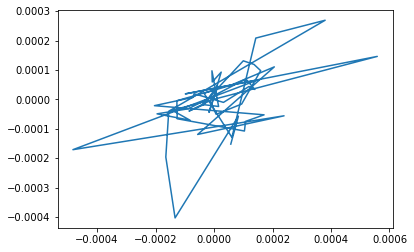

In [ ]:
import matplotlib.pyplot as plt
x_list = []
y_list = []
result = []
for idx in range(0,len(speed_vector_list)):
    x_list.append(speed_vector_list[idx][0])
    y_list.append(speed_vector_list[idx][1])
result = [x_list,y_list]
plt.plot(x_list,y_list)
plt.show()

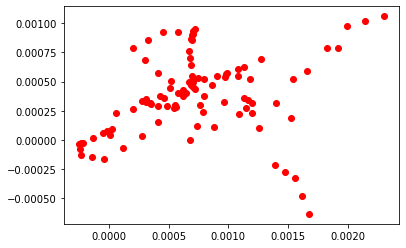

In [94]:
xn_list = []
yn_list = []
import matplotlib.pyplot as plt

for i in range(0,len(speed_vector_list)):
    if i == 0:
        xn_list.append(speed_vector_list[i][0])
        yn_list.append(speed_vector_list[i][1])
        
    else:
        xn_data = speed_vector_list[i][0] + xn_list[i-1]
        yn_data = speed_vector_list[i][1] + yn_list[i-1]
        xn_list.append(xn_data)
        yn_list.append(yn_data)

plt.plot(xn_list,yn_list,'ro')
plt.show()

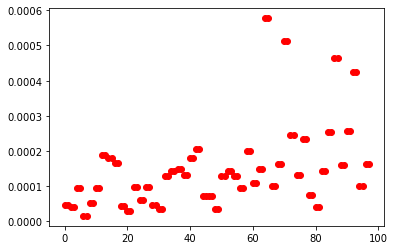

In [ ]:
plt.plot(norm_list, 'ro')
plt.show()

In [95]:
#GPS FIllering by Clustering for weight_centroid Filter
def weight_centroid_Filter():
    weight_centroid_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
    weight_centroid_cluster_list = [] #clustering list
    clustering_size = 10
    res_list = []
    Depth_Level = 2 # must even constant
        
    weight_centroid_point_list = [] # filtering point list
    ######################################################################

    for count in test_df.index.values[120:131]:
        marker_point_lati = float(merge_df.loc[count,'latitude'])
        marker_point_long = float(merge_df.loc[count,'longitude'])
        if merge_df.loc[count,'SATELLITE COUNT'] == np.nan : #위성정보가 오류로 수집이 안되었을 경우 0으로 처리
            marker_point_count = 0 # weight
        else:
            marker_point_count = int(merge_df.loc[count,'SATELLITE COUNT']) # weight
        marker_point = [marker_point_lati, marker_point_long, marker_point_count]
        
        if len(weight_centroid_cluster_list) != clustering_size: # cluster_list isnot full
            weight_centroid_cluster_list.append(marker_point)
            continue
    
        else : # cluster_list full
            while True:
                res_list.append(weight_centroid_cluster_list) # depth별 list
                if len(weight_centroid_cluster_list) == Depth_Level:
                    for index in range(0, len(res_list)): # 지도에 표시하기 위해 list에서 weight 제거 작업
                        for count in range(0, len(res_list[index])):
                            res_list[index][count] = res_list[index][count][:2]
                    break
                for point in range(0, len(weight_centroid_cluster_list)-2): # Depth Level 1
                    current_point = weight_centroid_cluster_list[point]
                    second_point = weight_centroid_cluster_list[point+1]
                    third_point = weight_centroid_cluster_list[point+2]
                    
                    weight_centroid_point_x = (current_point[2]*current_point[0] + second_point[2]*second_point[0] + third_point[2]*third_point[0])/(current_point[2]+second_point[2]+third_point[2]) #기존 내분점 공식을 그대로 적용하면 x, 변형 필요
                    weight_centroid_point_y = (current_point[2]*current_point[1] + second_point[2]*second_point[1] + third_point[2]*third_point[1])/(current_point[2]+second_point[2]+third_point[2])
                    weight_centroid_point_count = current_point[2] + second_point[2] + third_point[2]
                    weight_centroid_point = [weight_centroid_point_x, weight_centroid_point_y, weight_centroid_point_count]

                    weight_centroid_point_list.append(weight_centroid_point)
                weight_centroid_cluster_list = weight_centroid_point_list
                weight_centroid_point_list =[] # weight_centroid_point_list clear

    # folium.PolyLine(locations=weight_centroid_cluster_list,tooltip='Polyline', color='blue').add_to(weight_centroid_map) # draw line
    for index in range(0, len(res_list)):
        folium.PolyLine(locations=res_list[index],tooltip='Polyline', color=line_color_list[index]).add_to(weight_centroid_map)

    # weight_centroid_map  
